# Previsão de Preços de Tomate no Atacado

## Contexto

Este trabalho busca encontrar uma solução que faz a previsão de preços para tomates vendidos por produtores(atacado). Como forma de auxiliar agricultores a tomarem a melhor decisão durante o ciclo de sua lavoura.

Para isso será elaborado um modelo que com base em dados passados, como o próprio preço, conseguirá predizer valores futuros.


## Pergunta de Negócio

Durante o ciclo de uma lavoura o preço do tomate tende a oscilar periodicamente, de modo que para o agricultor é difícil de projetar resultados da sua lavoura de maneira precisa, o que dificulta a gestão de sua lavoura no dia a dia.

Com base nisso o nosso modelo busca entregar uma solução confiável que possa orientar o agricultor tanto na projeção de resultado como também de maneira estratégica para a gestão da lavoura.


## Importações

In [69]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings
warnings.filterwarnings('ignore')


## Bases de Dados

A base de dados utilizada nesse projeto, pode ser encontrada no site da [HF Brasil](https://www.hfbrasil.org.br/br/banco-de-dados-precos-medios-dos-hortifruticolas.aspx). HF Brasil é parte do CEPEA - Centro de Estudos Avançados em Economia Aplicada, da ESALQ - Escola Superior de Agricultura "Luiz de Queiroz", reúne pesquisadores e analistas de mercados, dedicados aos aspectos econômicos dos setores de frutas e hortaliças. Possui como missão produzir informações de qualidade pautadas em valores como imparcialidade e ética,que contribuam para o desenvolvimento sustentável dos setores estudados.

Também foi utilizado para este trabalho os dados cimáticos adquiridos do Banco de Dados Meteorológicos do INMET - Instituto Nacional de Metereologia,[INMET](https://portal.inmet.gov.br/dadoshistoricos),

### Sobre as bases de dados
A base de dados inicialmente utilizada foi um arquivo gerado direto do site da HF Brasil, em formato .xlsx, que trazia de maneira geral informações sobre a venda de tomate no atacado no período de janeiro de 2015 á abril de 2023, essa base de dados continha as informações de Produto, Região, Dia, Mês, Ano, Moeda, Unidade e Preço.

Com o desenvolvimento do projeto também foi utilizado a base de dados climática do INMET, nele foi feito um tratamento inicial para juntar os dados anuais, e selecionado as features que tinha maior relevância para o modelo.

Abaixo segue os dataframes das bases de dados utilizadas.

In [70]:
df = pd.read_excel('tomate-precos-medios.xlsx')
display(df)
clima = pd.read_csv('clima.csv')
display(clima)

,Produto,Região,Dia,Mês,Ano,Moeda,Unidade,Preço
0,Italiano - atacado,Campinas,14,4,2023,R$,Caixa 20 kg,86.67
1,Italiano - atacado,São Paulo (capital),14,4,2023,R$,Caixa 20 kg,65.00
2,Italiano 3A AT - Tomate,Campinas,14,4,2023,R$,Caixa 20 kg,150.00
3,Italiano 3A AT - Tomate,Rio de Janeiro (capital),14,4,2023,R$,Caixa 20 kg,100.00
4,Italiano 3A AT - Tomate,São Paulo (capital),14,4,2023,R$,Caixa 20 kg,113.33
...,...,...,...,...,...,...,...,...
32853,Salada longa vida AA - atacado,Rio de Janeiro (capital),2,1,2015,R$,Caixa 20 kg,31.75
32854,Salada longa vida AA - atacado,São Paulo (capital),2,1,2015,R$,Caixa 20 kg,31.38
32855,Salada longa vida AA - produtor,Itapeva (região),2,1,2015,R$,Caixa Aberta,26.67
32856,Santa Cruz AA - atacado,Campinas,2,1,2015,R$,Caixa 20 kg,31.00


,Data,Precipitacao,Temperatura,Umidade
0,2015-01-01,0.325000,27.479167,78.958333
1,2015-01-02,0.125000,26.537500,79.625000
2,2015-01-03,0.033333,26.270833,76.458333
3,2015-01-04,0.983333,24.508333,88.666667
4,2015-01-05,0.000000,21.845833,76.541667
...,...,...,...,...
3068,2023-05-27,0.000000,21.209091,65.318182
3069,2023-05-28,0.000000,21.227273,67.045455
3070,2023-05-29,0.000000,21.262500,71.791667
3071,2023-05-30,0.216667,20.420833,73.041667


Porém devido as necessidades do projeto essa base de dados foi alterada e reutilizada como será visto mais a frente.

## Análise Exploratória dos Dados

Inicialmente foi feito uma análise exploratória dos dados buscando verificar a qualidade dos dados. Também foi feito as customizações necessárias tal como a limpeza e verificação das características dos dados. Após isso foi feito o estudo dos dados.

### Qualidade dos Dados

In [71]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32858 entries, 0 to 32857
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Produto  32858 non-null  object 
 1   Região   32858 non-null  object 
 2   Dia      32858 non-null  int64  
 3   Mês      32858 non-null  int64  
 4   Ano      32858 non-null  int64  
 5   Moeda    32858 non-null  object 
 6   Unidade  32858 non-null  object 
 7   Preço    32858 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


None

,Dia,Mês,Ano,Preço
count,32858.000000,32858.000000,32858.000000,32858.000000
mean,15.701990,6.439802,2018.679713,48.524204
std,8.706996,3.310749,2.311127,24.767364
min,1.000000,1.000000,2015.000000,7.000000
25%,8.000000,4.000000,2017.000000,30.000000
50%,16.000000,6.000000,2019.000000,43.330000
75%,23.000000,9.000000,2021.000000,61.670000
max,31.000000,12.000000,2023.000000,195.000000


### Limpeza dos dados e Customização

In [72]:
def escalona_df(df):
    df.drop_duplicates(inplace = True)
    df.astype({'Dia':'int32','Mês':'int32','Ano':'int32'})
    df = df.astype({'Dia':str,'Mês':str,'Ano':str})
    df['Data'] = df[['Dia','Mês','Ano']].agg('-'.join,axis=1)
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    df = df.sort_values(by=["Região","Produto","Unidade","Data"])
    return df
def aumento_e_acelaracao(df):
    regioes = np.array(df['Região'].unique())
    produtos = np.array(df['Produto'].unique())
    unidades = np.array(df['Unidade'].unique())
    df_list = []
    for regiao in regioes:
        for produto in produtos:
            for unidade in unidades:
                df_aux = df.loc[(df["Unidade"] == unidade) & (df['Produto'] == produto) & (df['Região'] == regiao)].reset_index()
                df_aux['Aumento'] = df_aux['Preço'].diff()
                df_aux['Aceleracao'] = df_aux['Aumento'].diff()
                df_list.append(df_aux)
    columns = df.columns
    df_tratado = pd.DataFrame(columns=columns)
    for dataframe in df_list:
        if dataframe.shape[0] > 10:
            df_tratado = pd.concat([df_tratado,dataframe],ignore_index=True)
    return df_tratado

In [73]:
df = escalona_df(df)
df = aumento_e_acelaracao(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32731 entries, 0 to 32730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     32731 non-null  object        
 1   Região      32731 non-null  object        
 2   Dia         32731 non-null  object        
 3   Mês         32731 non-null  object        
 4   Ano         32731 non-null  object        
 5   Moeda       32731 non-null  object        
 6   Unidade     32731 non-null  object        
 7   Preço       32731 non-null  float64       
 8   Data        32731 non-null  datetime64[ns]
 9   index       32731 non-null  float64       
 10  Aumento     32701 non-null  float64       
 11  Aceleracao  32671 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 3.0+ MB


## Estudo dos Dados

Verificação das Regiões

São Paulo (capital)         9868
Campinas                    6693
Rio de Janeiro (capital)    3772
Belo Horizonte (capital)    2254
Venda Nova do Imigrante     2000
Araguari                    1478
Paty do Alferes (região)    1261
Mogi Guaçu (região)         1024
Chapada Diamantina          1015
Itapeva (região)             965
Sumaré (região)              821
São José de Ubá (região)     677
Caçador (região)             643
Norte do Paraná              260
Name: Região, dtype: int64


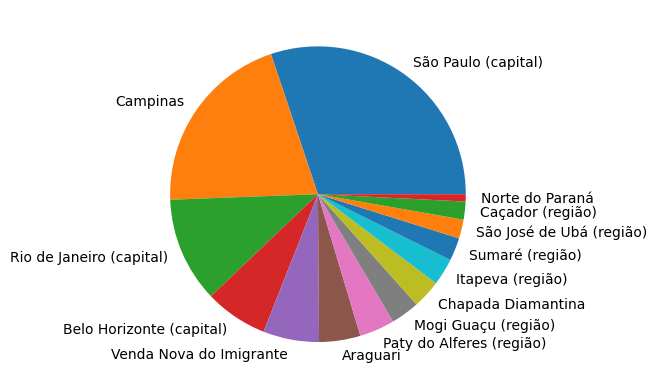

In [74]:
regiao_dist = df['Região'].value_counts()
print(regiao_dist)
plt.pie(regiao_dist,labels=regiao_dist.index)
plt.show()

Com o gráfico acima é visto que mais de 30% dos valores estão concentrados na região de São Paulo. Dessa forma seguiremos somente com a regia de São Paulo visto que o peso dos preços nesta região é maior e mais preciso.

Verificação das Unidades, com relação as Regiões selecionadas

In [75]:
df_sp = df.loc[df['Região']=="São Paulo (capital)"].sort_values(by=["Produto","Data"])

São Paulo: Caixa 20 kg    9868
Name: Unidade, dtype: int64


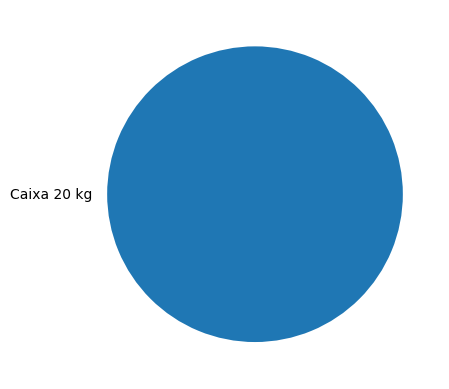

In [76]:
unidade_dist_sp = df_sp['Unidade'].value_counts()
print(f"São Paulo: {unidade_dist_sp}")
plt.pie(unidade_dist_sp,labels=unidade_dist_sp.index)
plt.show()

Como visto há apenas unidades do tipo "Caixa 20Kg"

Verificação quanto aos produtos relacionado com os Anos das amostras

In [77]:
produto_dist_sp = df_sp['Produto'].value_counts()
print(f"São Paulo: {produto_dist_sp}")
fig = px.histogram(df_sp, x='Ano',color='Produto',text_auto=True,width=1000, height=500)
fig.update_layout(title = "Distribuição de valores disponíveis por Ano em São Paulo")
fig.show()

São Paulo: Salada longa vida AA - atacado    2007
Italiano - atacado                2003
Italiano 3A AT - Tomate           1720
Salada 3A AT - Tomate             1720
Santa Cruz AA - atacado           1313
Santa Cruz 3A AT - Tomate         1042
Rasteiro - atacado                  63
Name: Produto, dtype: int64


Como verificado apenas os Produtos dos Tipos "Italiano - atacado" e "Salada longa Vida AA - atacado" estão presentes nas duas regiões e em todos os anos. Dessa forma será prosseguido somente com essas duas qualidades

### Considerações

Com as informações acima foi buscado novamente os dados na fonte, dessa vez pegando desde o ano de 2000 até o ano de 2023, e separando em duas bases de dados, São Paulo e Campinas, pegando um espaço de tempo maior para as duas regiões. Deixando a base a base de dados mais robusta.

In [78]:
df_sao_paulo = pd.read_excel("tomate-precos-medios-sao-paulo.xlsx")

In [79]:
df_sao_paulo = escalona_df(df_sao_paulo)
df_sao_paulo = aumento_e_acelaracao(df_sao_paulo)
df_sao_paulo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     19536 non-null  object        
 1   Região      19536 non-null  object        
 2   Dia         19536 non-null  object        
 3   Mês         19536 non-null  object        
 4   Ano         19536 non-null  object        
 5   Moeda       19536 non-null  object        
 6   Unidade     19536 non-null  object        
 7   Preço       19536 non-null  float64       
 8   Data        19536 non-null  datetime64[ns]
 9   index       19536 non-null  float64       
 10  Aumento     19529 non-null  float64       
 11  Aceleracao  19522 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 1.8+ MB


In [80]:
def calc_media_movel(df):
  df["Media 5"] = df["Preço"].rolling(window=5).mean()
  df["Media 10"] = df["Preço"].rolling(window=10).mean()
  df["Media 20"] = df["Preço"].rolling(window=20).mean()
  df["Aumento 5"] = df["Aumento"].rolling(window=5).mean()
  df["Aumento 10"] = df["Aumento"].rolling(window=10).mean()
  df["Aumento 20"] = df["Aumento"].rolling(window=20).mean()
  df["Aceleracao 5"] = df["Aceleracao"].rolling(window=5).mean()
  df["Aceleracao 10"] = df["Aceleracao"].rolling(window=10).mean()
  df["Aceleracao 20"] = df["Aceleracao"].rolling(window=20).mean()
  return df

def calc_min_max(df):
  df["Min 10"] = df["Preço"].rolling(window=10).min()
  df["Max 10"] = df["Preço"].rolling(window=10).max()
  return df

def set_data_index(df):
  df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')
  return df

def convert_columns(df):
  df['Dia'] = pd.to_numeric(df['Dia'])
  df['Mês'] = pd.to_numeric(df['Mês'])
  df['Ano'] = pd.to_numeric(df['Ano'])
  return df

def clima():
  df_clima = pd.read_csv('clima.csv')
  df_clima['Data'] = pd.to_datetime(df_clima['Data'], format='%Y-%m-%d')
  df_clima = df_clima.set_index(pd.DatetimeIndex(df_clima['Data'].values))
  df_clima_shifted = df_clima_shifted = pd.read_csv('clima.csv')
  df_clima_shifted['Data'] = pd.to_datetime(df_clima_shifted['Data'], format='%Y-%m-%d')
  df_clima_shifted = df_clima_shifted.set_index(pd.DatetimeIndex(df_clima_shifted['Data'].values))
  df_clima_shifted = df_clima_shifted.shift(periods=-5)
  df_clima_shifted.drop(axis=1,columns=['Data'],inplace=True)
  df_clima_shifted = df_clima_shifted.rename(columns={
      'Precipitacao':'Precipitacao de 5 dias',
      'Temperatura':'Temperatura de 5 dias',
      'Umidade':'Umidade de 5 dias'
  })
  df_clima = pd.merge(df_clima,df_clima_shifted,left_index=True, right_index=True)
  return df_clima

def format_df(df):
  df = calc_media_movel(df)
  df = calc_min_max(df)
  df = convert_columns(df)
  df = set_data_index(df)
  df.drop(axis=1,columns=['index','Moeda','Produto','Região','Unidade','Aumento','Aceleracao'],inplace=True)
  df = df.loc[df['Ano'] > 2014]
  df_clima = clima()
  df = pd.merge(df, df_clima, on='Data')
  df.fillna(method='backfill',inplace=True)
  df.dropna(inplace=True)
  return df

In [81]:
df_sp_salada_AA = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Salada longa vida AA - atacado"]
df_sp_italiano = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Italiano - atacado"]

In [82]:
df_sp_salada_AA = format_df(df_sp_salada_AA)
df_sp_italiano = format_df(df_sp_italiano)

## Modelo

### Tomate Salada AA

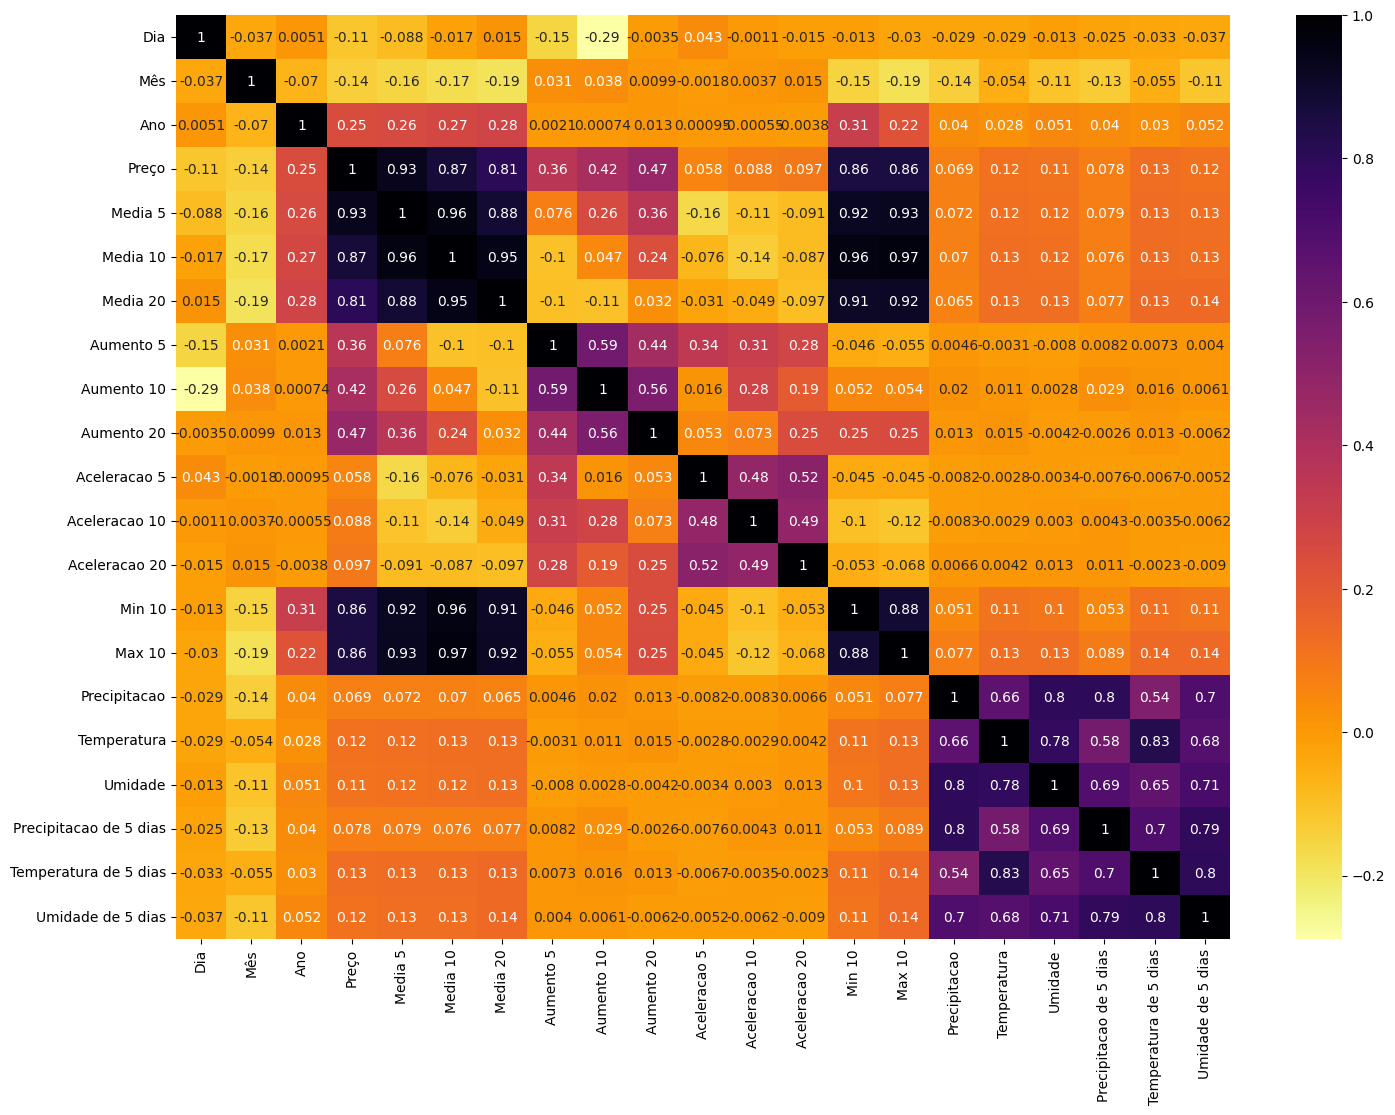

In [83]:
plt.figure(figsize=(17,12))
sns.heatmap(df_sp_salada_AA.corr(),annot=True,cmap="inferno_r")
plt.show()

In [84]:
x= df_sp_salada_AA[['Dia',
                   'Mês',
                   'Ano',
                   'Aumento 5',
                   'Aumento 10',
                   'Aumento 20',
                   'Aceleracao 5',
                   'Aceleracao 10',
                   'Aceleracao 20',
                   'Media 5',
                   'Media 10',
                   'Media 20',
                   'Min 10',
                   'Max 10',
                   'Precipitacao',
                   'Temperatura',
                   'Umidade',
                   'Precipitacao de 5 dias',
                   'Temperatura de 5 dias',
                   'Umidade de 5 dias']].values
y= df_sp_salada_AA[['Preço']].values

In [85]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [86]:
from sklearn.model_selection import cross_val_score
models={
 'LinearRegression':LinearRegression(),
 'Lasso':Lasso(),
 'Ridge':Ridge(),
 'GradientBoostingRegressor':GradientBoostingRegressor(),
 'AdaBoostRegressor':AdaBoostRegressor(),
 'RandomForestRegressor':RandomForestRegressor(),
 'KneghborsRegressor':KNeighborsRegressor()
}

In [87]:
for name, model in models.items():
 scores=cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
 print('ss validaton model:{}'.format(name))
 rmse=np.sqrt(-scores)
 rmse_avarage=np.mean(rmse)
 print('AVARAGE RMSE:',rmse_avarage)
 print('-'*20)


ss validaton model:LinearRegression
AVARAGE RMSE: 5.397717293715853
--------------------
ss validaton model:Lasso
AVARAGE RMSE: 3.149558439800211
--------------------
ss validaton model:Ridge
AVARAGE RMSE: 2.61343018802135
--------------------
ss validaton model:GradientBoostingRegressor
AVARAGE RMSE: 3.075700191280082
--------------------
ss validaton model:AdaBoostRegressor
AVARAGE RMSE: 5.0842834226310725
--------------------
ss validaton model:RandomForestRegressor
AVARAGE RMSE: 3.315750816456993
--------------------
ss validaton model:KneghborsRegressor
AVARAGE RMSE: 5.827948236018031
--------------------


In [88]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [89]:
LR = Ridge()

In [90]:
LR.fit(x_train,y_train)

Ridge()

In [91]:
print("model trained with {}".format(LR))
training_score = LR.score(x_train, y_train)*100
testing_score = LR.score(x_test, y_test)*100
score = r2_score(y_test, LR.predict(x_test))*100
mae = mean_absolute_error(y_test, LR.predict(x_test))
mse = mean_squared_error(y_test, LR.predict(x_test))
rmse = np.sqrt(mse)
print("r2score: ",score)
print("training_score: ", training_score)
print("testing_score: ", testing_score)
print("mae: ", mae)
print("mse: ", mse)
print("rmse_test: ", rmse)


model trained with Ridge()
r2score:  98.12526728051861
training_score:  98.50536534355766
testing_score:  98.12526728051861
mae:  1.8211778106307088
mse:  6.228062725613712
rmse_test:  2.4956086883992272


In [92]:
y_pred = LR.predict(x)

<Axes: xlabel='Data'>

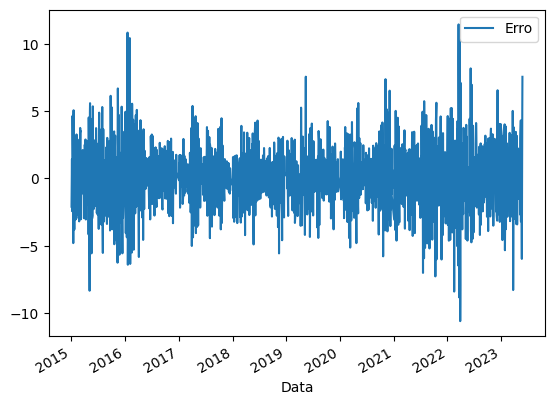

In [93]:
df_sp_salada_AA['Preço Predito'] = y_pred
df_sp_salada_AA['Erro'] = df_sp_salada_AA['Preço Predito'] - df_sp_salada_AA['Preço']
df_sp_salada_AA.plot.line(y='Erro',x='Data')

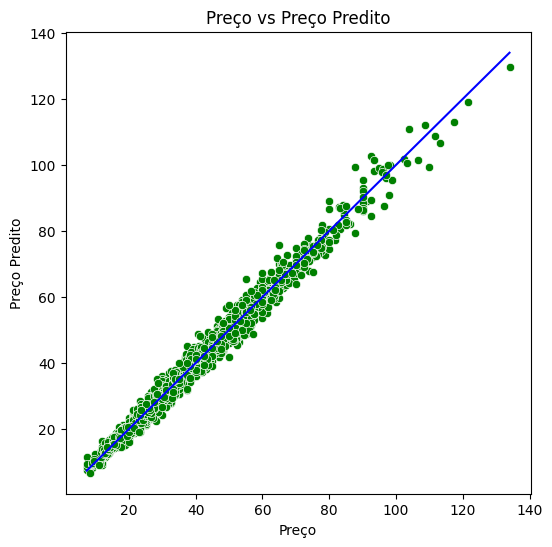

In [94]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = df_sp_salada_AA, x="Preço", y = "Preço Predito",color="green")
sns.lineplot(data = df_sp_salada_AA, x="Preço", y = "Preço",color="blue")
plt.title("Preço vs Preço Predito")
plt.show();

### Tomate Italiano

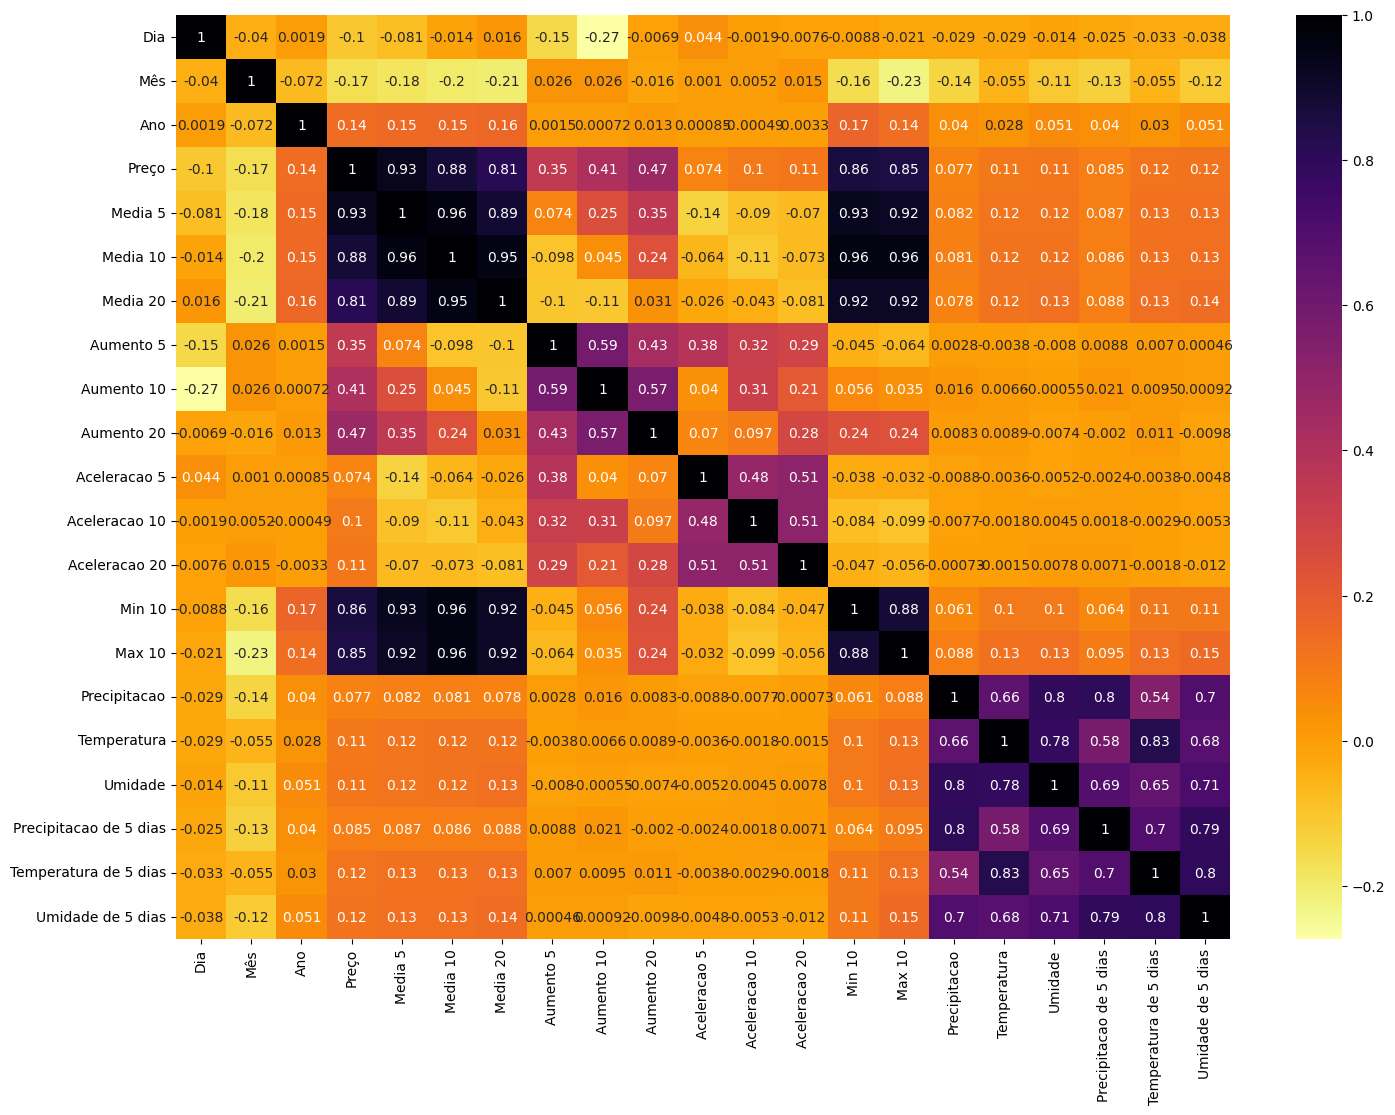

In [95]:
plt.figure(figsize=(17,12))
sns.heatmap(df_sp_italiano.corr(),annot=True,cmap="inferno_r")
plt.show()

In [96]:
x= df_sp_italiano[['Dia',
                   'Mês',
                   'Ano',
                   'Aumento 5',
                   'Aumento 10',
                   'Aumento 20',
                   'Aceleracao 5',
                   'Aceleracao 10',
                   'Aceleracao 20',
                   'Media 5',
                   'Media 10',
                   'Media 20',
                   'Min 10',
                   'Max 10',
                   'Precipitacao',
                   'Temperatura',
                   'Umidade',
                   'Precipitacao de 5 dias',
                   'Temperatura de 5 dias',
                   'Umidade de 5 dias']].values
y= df_sp_italiano[['Preço']].values

In [97]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [98]:
from sklearn.model_selection import cross_val_score
models={
 'LinearRegression':LinearRegression(),
 'Lasso':Lasso(),
 'Ridge':Ridge(),
 'GradientBoostingRegressor':GradientBoostingRegressor(),
 'AdaBoostRegressor':AdaBoostRegressor(),
 'RandomForestRegressor':RandomForestRegressor(),
 'KneghborsRegressor':KNeighborsRegressor()
}

In [99]:
for name, model in models.items():
 scores=cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
 print('ss validaton model:{}'.format(name))
 rmse=np.sqrt(-scores)
 rmse_avarage=np.mean(rmse)
 print('AVARAGE RMSE:',rmse_avarage)
 print('-'*20)


ss validaton model:LinearRegression
AVARAGE RMSE: 6.268687406793637
--------------------
ss validaton model:Lasso
AVARAGE RMSE: 3.346490377044695
--------------------
ss validaton model:Ridge
AVARAGE RMSE: 2.7272132784393555
--------------------
ss validaton model:GradientBoostingRegressor
AVARAGE RMSE: 3.4640226075939813
--------------------
ss validaton model:AdaBoostRegressor
AVARAGE RMSE: 5.166334954053112
--------------------
ss validaton model:RandomForestRegressor
AVARAGE RMSE: 3.557437415816776
--------------------
ss validaton model:KneghborsRegressor
AVARAGE RMSE: 6.005883142893002
--------------------


In [100]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [101]:
model = Ridge()

In [102]:
LR.fit(x_train,y_train)

Ridge()

In [103]:
print("model trained with {}".format(LR))
training_score = LR.score(x_train, y_train)*100
testing_score = LR.score(x_test, y_test)*100
score = r2_score(y_test, LR.predict(x_test))*100
mae = mean_absolute_error(y_test, LR.predict(x_test))
mse = mean_squared_error(y_test, LR.predict(x_test))
rmse = np.sqrt(mse)
print("r2score: ",score)
print("training_score: ", training_score)
print("testing_score: ", testing_score)
print("mae: ", mae)
print("mse: ", mse)
print("rmse_test: ", rmse)

model trained with Ridge()
r2score:  98.14770167623035
training_score:  98.21444666331057
testing_score:  98.14770167623035
mae:  1.9268637081422437
mse:  7.269845883180962
rmse_test:  2.696265173008946


In [104]:
y_pred = LR.predict(x)

<Axes: xlabel='Data'>

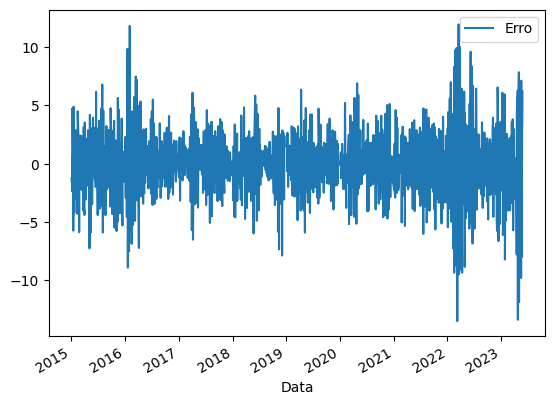

In [105]:
df_sp_italiano['Preço Predito'] = y_pred
df_sp_italiano['Erro'] = df_sp_italiano['Preço Predito'] - df_sp_italiano['Preço']
df_sp_italiano.plot.line(y='Erro',x='Data')

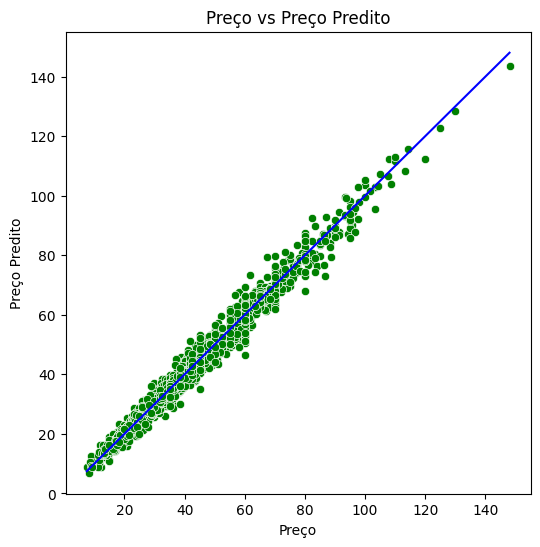

In [106]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = df_sp_italiano, x="Preço", y = "Preço Predito",color="green")
sns.lineplot(data = df_sp_italiano, x="Preço", y = "Preço",color="blue")
plt.title("Preço vs Preço Predito")
plt.show();